# Прогнозирование с помощью регрессии
Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке!

Вам понадобится много признаков. Некоторые из них у вас уже есть — это:

- идентификатор географической зоны
- дата и время
- количество поездок в периоды, предшествующие прогнозируемому
- синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
- Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!

Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования $\hat{y}_{T+1|T}$, другая для $\hat{y}_{T+2|T} $  и т.д.

## Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler as scaler
from sklearn.metrics import mean_absolute_error as mae
from itertools import product
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from datetime import timedelta

In [2]:
import xgboost as xgb

In [3]:
import warnings
warnings.simplefilter(action='ignore')

Загружаем список из 102 регионов для прогноза, отобранных на неделе 2

In [4]:
nonzero_reg=pd.read_csv("nonzero_regions.csv").iloc[:,1]

In [5]:
#nonzero_reg.index = range(1,103)

Загружаем аггрегированные данные за январь-июнь 2016. Отбираем для дальнейшего анализа данные только по отобранным 102 регионам

In [6]:
df_6=pd.read_csv("yellow_tripdata_2016-06.csv-agregated.csv")
df_5=pd.read_csv("yellow_tripdata_2016-05.csv-agregated.csv")
df_4=pd.read_csv("yellow_tripdata_2016-04.csv-agregated.csv")
df_3=pd.read_csv("yellow_tripdata_2016-03.csv-agregated.csv")
df_2=pd.read_csv("yellow_tripdata_2016-02.csv-agregated.csv")
df_1=pd.read_csv("yellow_tripdata_2016-01.csv-agregated.csv")

df=pd.concat([ df_1,df_2,df_3,df_4,df_5, df_6], axis=0)

In [7]:
df.rename(columns={'Unnamed: 0':'time'}, inplace=True)
df.index=df.time
df=df.iloc[:,nonzero_reg] 
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,80.0,144.0,50.0,77.0,319.0,402.0,531.0,617.0,846.0,267.0,...,12.0,0.0,2.0,44.0,5.0,41.0,4.0,70.0,7.0,66.0
2016-01-01 01:00:00,91.0,211.0,49.0,134.0,404.0,420.0,370.0,453.0,594.0,224.0,...,29.0,0.0,5.0,2.0,2.0,4.0,0.0,47.0,1.0,29.0
2016-01-01 02:00:00,90.0,146.0,23.0,110.0,393.0,425.0,313.0,366.0,377.0,138.0,...,47.0,0.0,3.0,0.0,4.0,0.0,0.0,69.0,1.0,14.0
2016-01-01 03:00:00,32.0,87.0,16.0,62.0,252.0,399.0,324.0,309.0,327.0,166.0,...,46.0,0.0,2.0,4.0,5.0,1.0,0.0,21.0,0.0,9.0
2016-01-01 04:00:00,24.0,43.0,10.0,53.0,145.0,254.0,264.0,333.0,318.0,145.0,...,43.0,0.0,0.0,1.0,1.0,0.0,0.0,26.0,1.0,6.0


Загружаем датасет с прогнозами ARIMA на январь-июнь, полученным на прошлой неделе

In [9]:
forecast=pd.read_csv('my_forecast.csv')
forecast.index=pd.to_datetime(forecast.time)
forecast=forecast.drop(['time','time.1'], axis=1)
forecast.head()

,region,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6
time,,,,,,,
2016-01-01 00:00:00,1129,561.537007,430.616793,285.951806,178.807926,117.415971,105.888219
2016-01-01 01:00:00,1129,463.908554,310.793132,204.536485,136.815019,121.546353,201.045148
2016-01-01 02:00:00,1129,304.245253,199.650651,131.754683,117.730915,197.965480,358.387592
2016-01-01 03:00:00,1129,236.719049,159.414024,146.378136,219.565168,375.821993,486.410010
2016-01-01 04:00:00,1129,202.800794,178.752060,253.095358,401.103385,506.816135,474.133056


In [18]:
forecast.shape

(445026, 7)

## Формирование тренировочного, валидационного и тестового датасетов 

1. Для каждой из шести задач прогнозирования $\hat{y}_{T+i|T}, i=1,\dots,6 $,i=1,…,6 сформируйте выборки. Откликом будет $y_{T+i}y $  при всевозможных значениях T, а признаки можно использовать следующие:
- идентификатор географической зоны — категориальный
- год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так
- синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
- сами значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $
- количество поездок из рассматриваемого района в моменты времени $y_T, y_{T-1}, \dots, y_{T-K}$ (параметр K можно подбирать; попробуйте начать, например, с 6)
- количество поездок из рассматриваемого района в моменты времени $y_{T-24}, y_{T-48}, \dots, y_{T-24*K_d}$ (параметр $K_d$ можно подбирать; попробуйте начать, например, с 2)
- суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц

Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании $\hat{y}_{T+i|T}, i=1,\dots,6 $
,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.

In [20]:

data = {}
time = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
t = np.arange(1,df.shape[0]+1)

for reg in list(nonzero_reg):
    data[reg] = pd.DataFrame({'y_t': df[str(reg)]})
    
    for i in range(1,13):
        y_t = "y_t" + str(i)
        data[reg][y_t] = data[reg]['y_t'].shift(i)
        
        
    for i in range(1,3):
        y_day = "y_day_" + str(i)
        data[reg][y_day] = data[reg]['y_t'].shift(i*24)
        
    data[reg]['reg'] = str(reg)
    data[reg]['month'] = time.month
    data[reg]['day'] = time.day
    data[reg]['weekday'] = time.weekday
    data[reg]['hour'] = time.hour
    
    for i in range(1, 30):
        sin = "s" + str(i)
        cos = "c" + str(i)
        data[reg][sin] = np.sin(2*i*np.pi*t/168)
        data[reg][cos] = np.cos(2*i*np.pi*t/168)
        
    for i in range(0,6):
        y_ = "y"+str(i+1)
        data[reg][y_] = data[reg]['y_t'].shift(-i-1)
        
    # Добавляем значения полученные моделью ARIMA
    data[reg] = pd.concat([data[reg], forecast[forecast['region']==reg]], axis=1)    
    data[reg] = data[reg].drop(['region'], axis=1)

In [21]:
forecast[forecast['region']==reg]

,region,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6
time,,,,,,,
2016-01-01 00:00:00,2168,60.201961,40.363130,11.503519,-4.738358,13.440273,49.969179
2016-01-01 01:00:00,2168,46.043071,17.067767,0.712554,18.780157,55.200297,75.974069
2016-01-01 02:00:00,2168,0.376752,-15.637765,2.762872,39.509262,60.602640,62.501238
2016-01-01 03:00:00,2168,-2.295489,15.832806,52.312979,73.145563,74.788678,72.503653
2016-01-01 04:00:00,2168,26.895333,63.149699,83.761553,85.188434,82.691580,73.640139
...,...,...,...,...,...,...,...
2016-06-30 14:00:00,2168,12.404512,10.552608,6.165714,5.681238,6.311521,7.571425
2016-06-30 15:00:00,2168,7.872068,4.932244,4.472892,5.127787,6.411802,8.974962
2016-06-30 16:00:00,2168,3.231138,3.690115,4.360955,5.660589,8.239050,10.187801


In [22]:
data[reg].head()

,y_t,y_t1,y_t2,y_t3,y_t4,y_t5,y_t6,y_t7,y_t8,y_t9,...,y3,y4,y5,y6,forecast_1,forecast_2,forecast_3,forecast_4,forecast_5,forecast_6
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,6.0,80.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 01:00:00,29.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,80.0,82.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 02:00:00,14.0,29.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,82.0,66.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 03:00:00,9.0,14.0,29.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN,...,82.0,66.0,92.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-01 04:00:00,6.0,9.0,14.0,29.0,66.0,NaN,NaN,NaN,NaN,NaN,...,66.0,92.0,88.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN


## Обучение прогнозных моделей и проверка их качества на валидационном датасете

**2.** Разбейте каждую из шести выборок на три части:

- обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
- тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
- итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016


In [23]:
delta1 = pd.to_datetime('2016-05-01 00:00:00') - pd.to_datetime('2016-01-01 00:00:00')
delta2 = pd.to_datetime('2016-05-31 23:00:00') - pd.to_datetime('2016-01-01 00:00:00')
delta3 = pd.to_datetime('2016-06-30 17:00:00') - pd.to_datetime('2016-01-01 00:00:00')

mayStartIndex = int(delta1.days*24 + delta1.seconds/3600)
mayEndIndex = int(delta2.days*24 + delta2.seconds/3600)
juneEndindex = int(delta3.days*24 + delta3.seconds/3600)
print(mayStartIndex)
print(mayEndIndex)
print(juneEndindex)

2904
3647
4361


In [24]:
X_train = pd.DataFrame()
X_valid= pd.DataFrame()
X_test = pd.DataFrame()

for reg in nonzero_reg:
    X_train = pd.concat([X_train, data[reg].iloc[0:mayStartIndex]], axis=0)
    X_valid = pd.concat([X_valid, data[reg].iloc[mayStartIndex-1:mayEndIndex-5]], axis=0)
    X_test = pd.concat([X_test, data[reg].iloc[mayEndIndex:juneEndindex]], axis=0)
    

In [25]:
# Кодируем номер региона, как категориальный признак

encoder = OneHotEncoder(drop='first')
regions = []

for reg in nonzero_reg[:-1]:
    regions.append('r_'+str(reg))
    
region_encoded_train = pd.DataFrame(encoder.fit_transform(X_train[['reg']]).toarray(), columns=regions, index=X_train.index)
region_encoded_valid = pd.DataFrame(encoder.fit_transform(X_valid[['reg']]).toarray(),columns=regions, index=X_valid.index)
region_encoded_test = pd.DataFrame(encoder.fit_transform(X_test[['reg']]).toarray(), columns=regions, index=X_test.index)

X_train = pd.concat([X_train.drop(['reg'], axis=1), region_encoded_train], axis=1)
X_valid = pd.concat([X_valid.drop(['reg'], axis=1), region_encoded_valid], axis=1)
X_test = pd.concat([X_test.drop(['reg'], axis=1), region_encoded_test], axis=1)

In [26]:
response_columns = {'y1', 'y2', 'y3', 'y4', 'y5', 'y6'}

In [27]:
response_train = X_train[response_columns]
train = X_train.drop(response_columns, axis=1)

response_valid = X_valid[response_columns]
valid = X_valid.drop(response_columns, axis=1)

response_test = X_test[response_columns]
test = X_test.drop(response_columns, axis=1)

test.head()

,y_t,y_t1,y_t2,y_t3,y_t4,y_t5,y_t6,y_t7,y_t8,y_t9,...,r_1580,r_1630,r_1684,r_1733,r_1734,r_1783,r_2068,r_2069,r_2118,r_2119
time,,,,,,,,,,,,,,,,,,,,,
2016-05-31 23:00:00,34.0,83.0,84.0,99.0,106.0,106.0,84.0,80.0,105.0,124.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 00:00:00,26.0,34.0,83.0,84.0,99.0,106.0,106.0,84.0,80.0,105.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 01:00:00,14.0,26.0,34.0,83.0,84.0,99.0,106.0,106.0,84.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 02:00:00,5.0,14.0,26.0,34.0,83.0,84.0,99.0,106.0,106.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-06-01 03:00:00,2.0,5.0,14.0,26.0,34.0,83.0,84.0,99.0,106.0,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



3. Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:

- допускала попарные взаимодействия между признаками
- была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)



In [28]:
# Для построения регрессионной модели будем использовать XGBoost
# обучим модели на тренировочной выборке
train_models = [xgb.XGBRegressor().fit(train, response_train[i]) for i in response_columns]

In [29]:
# Проверим на валидационной выборке
predict_on_valid = [model.predict(valid) for model in train_models]

In [30]:
predict_on_valid

[array([ 24.066856,  27.66992 ,  40.108913, ...,  95.22994 , 136.88838 ,
        118.80654 ], dtype=float32),
 array([ 24.488884 ,  16.627287 ,   6.4185085, ..., 119.430565 ,
        102.25791  ,  95.35873  ], dtype=float32),
 array([ 58.733936,  33.899273,  14.423379, ...,  90.65451 , 115.21567 ,
        107.33497 ], dtype=float32),
 array([ 33.57961 ,  28.763905,  16.550592, ..., 103.98141 , 129.63895 ,
        132.14653 ], dtype=float32),
 array([  8.089112,  54.649208,  64.47449 , ..., 112.17976 , 137.15463 ,
         82.285095], dtype=float32),
 array([ 72.75018 ,  47.240997,  29.877663, ...,  68.87343 , 125.01204 ,
        105.264046], dtype=float32)]

In [31]:
# По метрике mae оценим прогноз
[mae(predict, response_valid[i]) for predict, i in zip(predict_on_valid, response_columns)]

[26.586141344552445,
 25.449706630867137,
 21.532298029708873,
 24.24918277694324,
 27.533794558294524,
 17.256603494219448]

4. Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

$$Q_{may} =\frac1{R * 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30 23:00}^{2016.05.31 17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y^r_{T+i} \right|$$

Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу QQ, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.



In [32]:
def eval_quality(predict, valid_vals):
    diffs = [np.abs(valid_vals[i] - predict)[:-5].sum() for predict, i in zip(predict, response_columns)]
    return np.sum(diffs)/(739*6*102)

In [33]:
eval_quality(predict_on_valid, response_valid)

23.766169385255417

Значение Q уменьшилось по сравнению с прошлой неделей.

Попытаемся улучшить качество модели

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

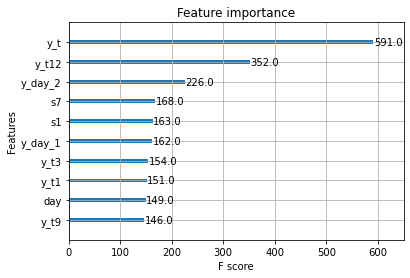

In [34]:
xgb.plot_importance(train_models[0], max_num_features=10)

In [35]:
train_models[0].get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [36]:
import hyperopt.hp as hp
from hyperopt import fmin, tpe, STATUS_OK, Trials

In [37]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 2),
        'reg_alpha' : hp.quniform('reg_alpha', 50,150,25),
         'n_estimators': hp.quniform("n_estimators", 10, 110, 50),
        'seed': 0
    }

In [38]:
def objective(space):
    
    regression=xgb.XGBRegressor(
        n_estimators =int(space['n_estimators']), 
        max_depth = int(space['max_depth']),
        reg_alpha = int(space['reg_alpha']))
    
    evaluation = [( train, response_train['y1']), ( valid, response_valid['y1'])]
    
    regression.fit(train,response_train['y1'], 
                   eval_set=evaluation, 
                   eval_metric="mae",
                   early_stopping_rounds=10,verbose=False)
    

    pred = regression.predict(valid)
    mae_pred = mae(response_valid['y1'],pred)
    print ("SCORE:", mae_pred)
    return {'loss': mae_pred, 'status': STATUS_OK}

In [39]:
trials = Trials()

In [40]:
%%time
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
18.03872984934855                                                                                                      
SCORE:                                                                                                                 
16.197464635094743                                                                                                     
SCORE:                                                                                                                 
16.190543716654755                                                                                                     
SCORE:                                                                                                                 
17.14383541664265                                                                                                      
SCORE:                                  

SCORE:                                                                                                                 
150.57183793679854                                                                                                     
SCORE:                                                                                                                 
150.57183793679854                                                                                                     
SCORE:                                                                                                                 
150.57183793679854                                                                                                     
SCORE:                                                                                                                 
150.57183793679854                                                                                                     
SCORE:                                  

In [41]:
print(best_hyperparams)

{'max_depth': 10.0, 'n_estimators': 50.0, 'reg_alpha': 150.0}


Обучим модели регрессии с наилучшими параметрами

In [42]:
train_models = [xgb.XGBRegressor(max_depth=10, 
                                 n_estimators=100, 
                                 reg_alpha=125).fit(train, response_train[i]) for i in response_columns]

In [43]:
predict_on_valid = [model.predict(valid) for model in train_models]

In [44]:
eval_quality(predict_on_valid, response_valid)

20.471174399468875

Небольшое улучшение качества модели по сравнению с параметрами по умолчанию.

5. Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [45]:
predict_on_test = [model.predict(test) for model in train_models]

In [46]:
eval_quality(predict_on_test, response_test)


20.379298831732083